# Open-shell examples

### For now, open-shell calculations support only linear and adaptive mixing schemes in SCF optimization. Pulay is for closed-shell only.
### + Single point and optimization can be done for open shells.
### - MD for open shells will be added soon.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/") # path to PySEQM

import torch
import seqm
from seqm.Molecule import Molecule
from seqm.seqm_functions.constants import Constants
from seqm.seqm_functions.make_dm_guess import make_dm_guess # for broken symetry initial guesses
from seqm.ElectronicStructure import Electronic_Structure # electronic structure driver
from seqm.MolecularDynamics import Geometry_Optimization_SD

seqm.seqm_functions.scf_loop.debug=False # controlls printing SCF info
seqm.seqm_functions.scf_loop.MAX_ITER = 600 # max SCF steps

DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# small systems are more efficiently computed on CPU
device = torch.device('cpu')

/home/maxim/anaconda3/envs/hipnn_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ground states of carbene (CH2) and O2 are triplets

In [2]:
# Atomic numbers need to sorted be in descending order
species = torch.as_tensor([
                            [6,1,1],
                            [8,8,0]
                          ], dtype=torch.int64, device=device)

coordinates = torch.tensor([
                            [[ 0.23,  0.08,  0.32],
                             [ 1.07, -0.06, -0.22],
                             [-0.61,  0.22,  0.88]],

                            [[ 0.00,  0.00,  0.03],
                             [ 0.00,  0.00,  1.13],
                             [ 0.00,  0.00,  0.00]]
    
                            ], device=device)

const = Constants().to(device)
elements = [0]+sorted(set(species.reshape(-1).tolist()))
seqm_parameters = {
                   'method' : 'PM6_SP', # AM1, MNDO, PM3, PM6, PM6_SP. PM6_SP is PM6 without d-orbitals. Effectively, PM6 for the first two rows of periodic table
                   'scf_eps' : 1.0e-6,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [0,0.5],# converger used for SCF loop
                                             # [0, alpha] constant linear mixing, P = alpha*P + (1.0-alpha)*Pnew
                                             # [1], adaptive mixing
                                             # [1, K, L, M], advanced adaptive mixing.
                                             #               First, it does linear mixing for M steps. Mixing coeff is K the first 5 SCF steps.
                                             #               Then it incrementally goes to L and becomes L at M-5 SCF step. From M-5 to M it's equal to L.
                                             #               After M'th SCF step, adaptive mixing begins.
                                             # 
                                             # [2], adaptive mixing, then pulay
                   'sp2' : [False, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   'eig' : True, # store MO energies
                   'UHF' : True, ### use spin-unrestricted formalism (open shell)
                   }

# Charge and multiplicity for each molecule in a batch need to be passed to a Molecule object.
# Otherwise, neutral singlets are assumed by default.
charges = torch.tensor([0,0],dtype=torch.int64, device=device)
mult = torch.tensor([3,3], device=device)
molecule = Molecule(const, seqm_parameters, coordinates, species, charges, mult).to(device)

# geometry optimization
opt =  Geometry_Optimization_SD(seqm_parameters, alpha=0.01, force_tol=1.0e-2, max_evl=400).to(device)
max_force, dE =  opt.run(molecule)

print('\nTotal energies:', molecule.Etot)

Step,  Max_Force,      Etot(eV),     dE(eV)
1      4.116831e-01 ||3.224979e+00 3.224979e+00 ||-7.541949e-01 -7.541949e-01 
2      2.158196e-01 ||3.223851e+00 -1.127876e-03 ||-7.549858e-01 -7.908699e-04 
3      1.110453e-01 ||3.223608e+00 -2.437025e-04 ||-7.552148e-01 -2.289652e-04 
4      5.940267e-02 ||3.223499e+00 -1.084921e-04 ||-7.552721e-01 -5.736370e-05 
5      3.511966e-02 ||3.223444e+00 -5.531265e-05 ||-7.552881e-01 -1.591425e-05 
6      2.591950e-02 ||3.223415e+00 -2.888366e-05 ||-7.552926e-01 -4.552837e-06 
7      1.925119e-02 ||3.223399e+00 -1.538030e-05 ||-7.552940e-01 -1.416794e-06 
8      1.435515e-02 ||3.223391e+00 -8.419744e-06 ||-7.552945e-01 -4.664362e-07 
9      1.077378e-02 ||3.223386e+00 -4.781366e-06 ||-7.552947e-01 -1.643690e-07 
10      8.362328e-03 ||3.223383e+00 -2.943751e-06 ||-7.552947e-01 -4.960384e-08 
converged with 10 step, Max Force = 8.362328e-03 (eV/Ang), dE = -1.496678e-06 (eV)

Total energies: tensor([-146.4011, -580.1751])


## Compare with energies of singlets

In [3]:
coordinates = torch.tensor([
                            [[ 0.00,  0.00,  0.00],
                             [ 1.08,  0.00,  0.01],
                             [-0.39,  0.24,  0.97]],

                            [[ 0.00,  0.00,  0.03],
                             [ 0.00,  0.00,  1.14],
                             [ 0.00,  0.00,  0.00]]
    
                            ], device=device)

charges = torch.tensor([0,0],dtype=torch.int64, device=device)
mult = torch.tensor([1,1], device=device)
molecule = Molecule(const, seqm_parameters, coordinates, species, charges, mult).to(device)

opt =  Geometry_Optimization_SD(seqm_parameters, alpha=0.01, force_tol=1.0e-2, max_evl=400).to(device)
max_force, dE =  opt.run(molecule)

print('\nTotal energies:', molecule.Etot)

Step,  Max_Force,      Etot(eV),     dE(eV)
1      1.596853e-01 ||4.593026e+00 4.593026e+00 ||1.809494e+00 1.809494e+00 
2      8.011179e-02 ||4.592697e+00 -3.286943e-04 ||1.809477e+00 -1.685616e-05 
3      4.317614e-02 ||4.592615e+00 -8.251366e-05 ||1.809473e+00 -3.535021e-06 
4      2.531305e-02 ||4.592587e+00 -2.740916e-05 ||1.809472e+00 -9.943396e-07 
5      1.634113e-02 ||4.592574e+00 -1.312518e-05 ||1.809472e+00 -3.416417e-07 
6      1.352779e-02 ||4.592566e+00 -8.392873e-06 ||1.809472e+00 -1.548336e-07 
7      1.252765e-02 ||4.592560e+00 -6.252763e-06 ||1.809472e+00 -7.195433e-08 
8      1.156583e-02 ||4.592555e+00 -4.985928e-06 ||1.809472e+00 -2.730735e-08 
9      1.063653e-02 ||4.592551e+00 -4.059514e-06 ||1.809472e+00 -3.053344e-08 
10      9.780423e-03 ||4.592547e+00 -3.355209e-06 ||1.809472e+00 5.453444e-09 
converged with 10 step, Max Force = 9.780423e-03 (eV/Ang), dE = -1.674878e-06 (eV)

Total energies: tensor([-145.0319, -577.6103])


# Open-shell singlet
## H2 and HF separation scans
### The symmetry of a wavefunction needs to be broken. Otherwise, closed-shell solution.

In [4]:
# equilibrium distances for H-H and H-F
HH_equilibrium = 0.7
HF_equilibrium = 0.9

# array for separation scan
d_r = np.linspace(0.0, 5, 26)

species = torch.as_tensor([
                       [1,1],
                       [9,1],
                            ],
                      dtype=torch.int64, device=device)
const = Constants().to(device)
elements = [0]+sorted(set(species.reshape(-1).tolist()))

### Broken symmetry open-shell bond scan. Here, a broken symmetry wfn guess is made for each point along the scan.

In [5]:
%%time

# arrays to record energies and charges from open-shell (OS) broken-symmetry (BS) calculations along bond separation scan
E_OS_BS = np.empty((0,2))
Q_OS_BS = np.empty((0,2,2))

# bond scan
for i in d_r:
    print('added distance: ', i)
    coordinates = torch.tensor([
        
                              [[0.00,    0.00,    0.00],
                               [0.00,    0.00,    HH_equilibrium + i]],
        
                              [[0.00,    0.00,    0.00],
                               [0.00,    0.00,    HF_equilibrium + i]],
        
                               ], device=device)
    
    seqm_parameters = {
                   'method' : 'PM6_SP',  # AM1, MNDO, PM#
                   'scf_eps' : 1.0e-5,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [1,0.8, 0.95, 15], # converger used for scf loop
                                           # [0, 0.1], [0, alpha] constant mixing, P = alpha*P + (1.0-alpha)*Pnew
                                           # [1], adaptive mixing
                                           # [1, K, L, M], advanced adaptive mixing.
                                           #               First, it does linear mixing for M steps. Mixing coeff is K the first 5 SCF steps.
                                           #               Then it incrementally goes to L and becomes L at M-5 SCF step. From M-5 to M it's equal to L.
                                           #               After M'th SCF step, adaptive mixing begins.
                                           # 
                                           # [2], adaptive mixing, then pulay
                   'sp2' : [False, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                                            #[True, eps] or [False], eps for SP2 conve criteria
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   'eig' : True,
                   'UHF' : True, # use unrestricted HF
                   }
    
    # neutral singlets by default if charges and multiplicities are not specified 
    molecule = Molecule(const, seqm_parameters, coordinates, species).to(device)
    
    ### Break the symmetry of a DM guess: HOMO_alpha = 0.1*HOMO + 0.9*LUMO   (mix_coeff=0.9)
    make_dm_guess(molecule, seqm_parameters, mix_homo_lumo=True, mix_coeff=0.9, overwrite_existing_dm=True);
    
    # Single point calculation with the current bond length
    esdriver = Electronic_Structure(seqm_parameters).to(device)
    esdriver(molecule, P0=molecule.dm) # molecule.dm is a guess assigned to molecule after calling make_dm_guess
    
    # store energies and charges
    E_OS_BS = np.vstack((E_OS_BS,molecule.Etot.cpu().numpy()))
    Q_OS_BS = np.vstack((Q_OS_BS,[molecule.q.cpu().numpy()]))
    


added distance:  0.0


/home/maxim/Projects/git2/PYSEQM_dev/seqm/seqm_functions/make_dm_guess.py:270: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  v_lumo = v[:,0].gather(2, molecule.nocc[:,0].unsqueeze(0).unsqueeze(0).T.repeat(1,v.shape[-1],1))


added distance:  0.2
added distance:  0.4
added distance:  0.6000000000000001
added distance:  0.8
added distance:  1.0
added distance:  1.2000000000000002
added distance:  1.4000000000000001
added distance:  1.6
added distance:  1.8
added distance:  2.0
added distance:  2.2
added distance:  2.4000000000000004
added distance:  2.6
added distance:  2.8000000000000003
added distance:  3.0
added distance:  3.2
added distance:  3.4000000000000004
added distance:  3.6
added distance:  3.8000000000000003
added distance:  4.0
added distance:  4.2
added distance:  4.4
added distance:  4.6000000000000005
added distance:  4.800000000000001
added distance:  5.0
CPU times: user 3min 11s, sys: 3.64 s, total: 3min 14s
Wall time: 9.81 s


###  Closed-shell (equivalent to open-shell without breaking the symetry).

In [6]:
%%time

# arrays to record energies and charges from closed-shell (CS) calculations along bond separation scan
E_CS = np.empty((0,2))
Q_CS = np.empty((0,2,2))

# Closed-shell bond separation is problematic to converge.
# Here, density matrix (dm) from the previous point on the scan is used as a guess for the next one to accelerate convergence
dm=None 
for i in d_r:
    print('Bond length:', i)
    coordinates = torch.tensor([
                              [[ 0.00,    0.00,    0.00],
                               [ 0.00,    0.00,    HH_equilibrium+i]],
        
                              [[0.00,    0.00,    0.00],
                               [0.00,    0.00,    HF_equilibrium+i]],
                            ], device=device)
    
    seqm_parameters = {
                   'method' : 'PM6_SP',  # AM1, MNDO, PM#
                   'scf_eps' : 1.0e-5,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [0, 0.5], # converger used for scf loop
                                         # [0, 0.1], [0, alpha] constant mixing, P = alpha*P + (1.0-alpha)*Pnew
                                         # [1], adaptive mixing
                                         # [2], adaptive mixing, then pulay
                   'sp2' : [False, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                                            #[True, eps] or [False], eps for SP2 conve criteria
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   #'parameter_file_dir' : '../seqm/params/', # file directory for other required parameters
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   'eig' : True,
                   'scf_backward' : 0,
                   'UHF' : False, # use unrestricted HF
                   }
    
    molecule = Molecule(const, seqm_parameters, coordinates, species).to(device)
    esdriver = Electronic_Structure(seqm_parameters).to(device)
    esdriver(molecule, P0=dm)
    dm = molecule.dm.clone() # store density matrix for the initial guess in the next step
    
    # store energies and charges
    E_CS = np.vstack((E_CS,molecule.Etot.cpu().numpy()))
    Q_CS = np.vstack((Q_CS,[molecule.q.cpu().numpy()]))
    

Bond length: 0.0
Bond length: 0.2
Bond length: 0.4
Bond length: 0.6000000000000001
Bond length: 0.8
Bond length: 1.0
Bond length: 1.2000000000000002
Bond length: 1.4000000000000001
Bond length: 1.6
Bond length: 1.8
Bond length: 2.0
Bond length: 2.2
Bond length: 2.4000000000000004
Bond length: 2.6
Bond length: 2.8000000000000003
Bond length: 3.0
Bond length: 3.2
Bond length: 3.4000000000000004
Bond length: 3.6
Bond length: 3.8000000000000003
Bond length: 4.0
Bond length: 4.2
Bond length: 4.4
Bond length: 4.6000000000000005
Bond length: 4.800000000000001
Bond length: 5.0
CPU times: user 1min 4s, sys: 1.3 s, total: 1min 6s
Wall time: 3.4 s


### H-H separation energy curve.

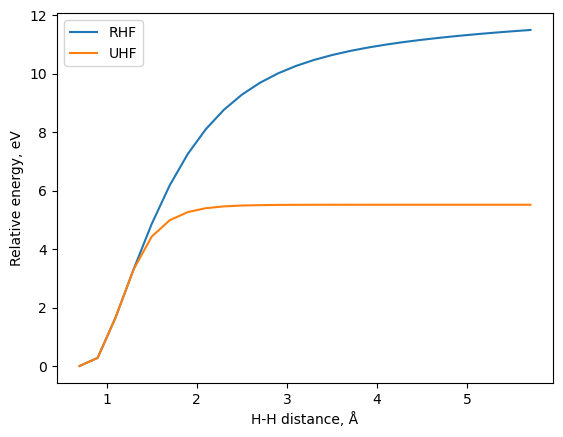

In [7]:
plt.plot(d_r + HH_equilibrium, E_CS[:,0] - min(E_CS[:,0]), label='RHF')
plt.plot(d_r + HH_equilibrium, E_OS_BS[:,0] - min(E_OS_BS[:,0]), label='UHF')
plt.legend()
plt.xlabel('H-H distance, Å')
plt.ylabel('Relative energy, eV')
plt.show()

### H-F separation energy curve.

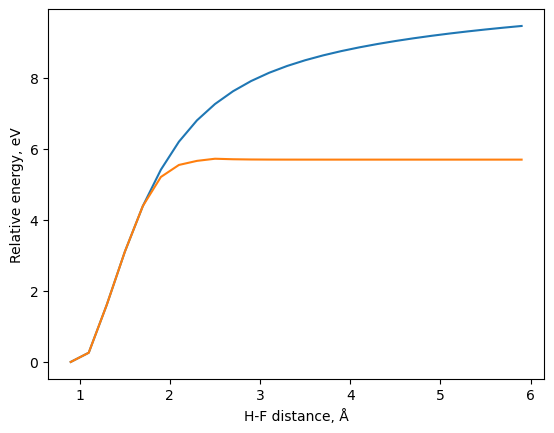

In [8]:
plt.plot(d_r + HF_equilibrium, E_CS[:,1]-min(E_CS[:,1]), label='RHF')
plt.plot(d_r + HF_equilibrium, E_OS_BS[:,1] - min(E_OS_BS[:,1]), label='UHF')
plt.xlabel('H-F distance, Å')
plt.ylabel('Relative energy, eV')
plt.show()

### Charges on F and H at equilibrium distance.

#### Broken symmetry open-shell singlet

In [9]:
# F                    H
Q_OS_BS[:,1,0][0], Q_OS_BS[:,1,1][0]

(-0.26185603434791105, 0.26185603488846465)

#### Closed-shell singlet

In [10]:
# F                    H
Q_CS[:,1,0][0], Q_CS[:,1,1][0]

(-0.2620707050711424, 0.26207070507114194)

### Charges on F and H at 6 Å distance.

#### Broken symmetry open-shell singlet. Almost zero, which is correct for homolytic separation.

In [11]:
# F                    H
Q_OS_BS[:,1,0][-1], Q_OS_BS[:,1,1][-1]

(-6.78469724846309e-10, 1.2399326772366638e-08)

#### Closed-shell singlet. Non-zero charges, which is incorrect. In gas phase, separation should proceed homolytically.

In [12]:
# F                    H
Q_CS[:,1,0][-1], Q_CS[:,1,1][-1]

(-0.4066206075601775, 0.4066206075601766)